# Spectragram representation

In [1]:
import os
import sys
import cv2
import pickle

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

C:\Users\Administrator\.conda\envs\torch1.12.1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\trails10\experiment_1_10trials


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

In [4]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")
data = pickle.load(open(training_data_kok14_galfa, 'rb'))

# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

In [5]:
print("x_train = ", X_train.shape)
print("Y_train = ", Y_train.shape)
print("X_test = ", X_test.shape)
print("Y_test = ", Y_test.shape)

x_train =  (38781, 414)
Y_train =  (38781, 2)
X_test =  (58, 414)
Y_test =  (58, 2)


## Split train, validation and testing set from X_train and Y_train.

In [6]:
x_train = X_train[0:23268, :]
y_train = Y_train[0:23268, :]

x_val = X_train[23268: 31024, :]
y_val = Y_train[23268: 31024, :]

x_test = X_train[31024:, :]
y_test = Y_train[31024:, :]

In [7]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


# Display few training samples

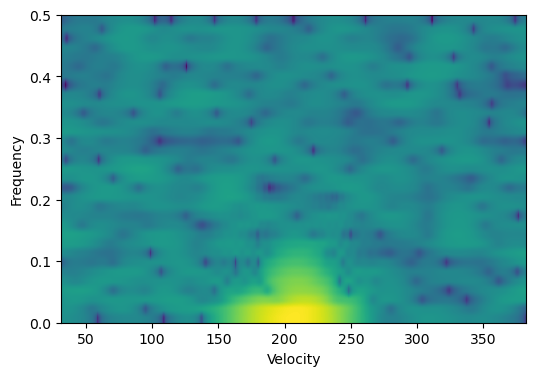

In [8]:
x = x_train[0, :]

plt.figure(figsize=(6,4))
plt.xlabel("Velocity")
plt.ylabel("Frequency")
ws = 64
spectrum, freqs,t,im = plt.specgram(x, Fs=1, NFFT = ws, noverlap=ws-1)
torch_tensor = torch.from_numpy(spectrum)
#print(spectrum.shape)
#plt.show(10*np.log10(torch_tensor))
plt.show()

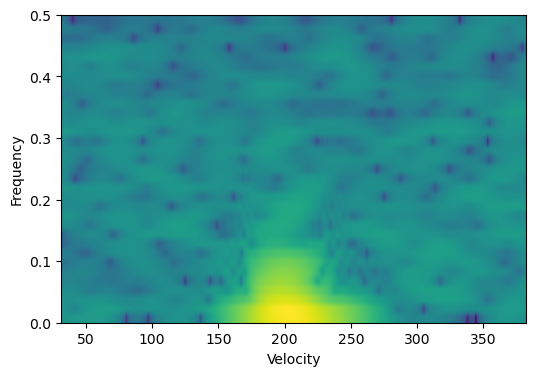

In [9]:
x = x_train[1000, :]

plt.figure(figsize=(6,4))
plt.xlabel("Velocity")
plt.ylabel("Frequency")
ws = 64
spectrum, freqs,t,im = plt.specgram(x, Fs=1, NFFT = ws, noverlap=ws-1)
torch_tensor = torch.from_numpy(spectrum)
#print(spectrum.shape)
#plt.show(10*np.log10(torch_tensor))
plt.show()

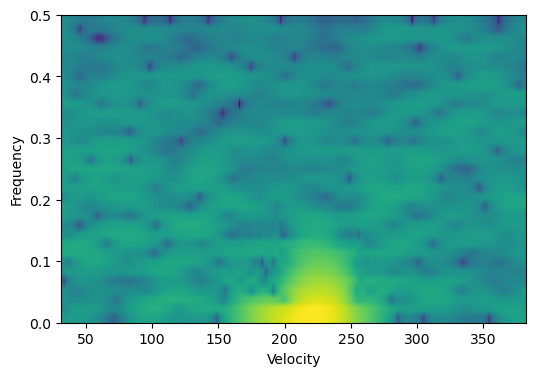

In [10]:
x = x_train[10000, :]

plt.figure(figsize=(6,4))
plt.xlabel("Velocity")
plt.ylabel("Frequency")
ws = 64
spectrum, freqs,t,im = plt.specgram(x, Fs=1, NFFT = ws, noverlap=ws-1)
torch_tensor = torch.from_numpy(spectrum)
#print(spectrum.shape)
#plt.show(10*np.log10(torch_tensor))
plt.show()

# Data Loader

In [11]:
# data loader 
class HI_dataset(torch.utils.data.Dataset):
    def __init__(self, x_path, y, transform=None, target_transform=None):
        self.y = y
        self.x_path = x_path
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        #print("idx=",idx)
        filename = f'{idx}.jpg'
        spectra = cv2.imread(os.path.join(self.x_path,filename))
        spectra = cv2.cvtColor(spectra, cv2.COLOR_BGR2RGB)
        label = self.y[idx,:].reshape(1, -1)
        #label = label.view(1, -1)
        #print(spectra.shape)
        if self.transform:
            spectra = self.transform(spectra)
            spectra = spectra.view(3,spectra.shape[0], spectra.shape[1])
        if self.target_transform:
            label = self.target_transform(label)
        return spectra, label

In [12]:
# transform to tenor 
class ToTensor_x():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [13]:
# transform to tenor 
class ToTensor_y():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        x =x.squeeze()
        return x

In [14]:
# initialize dataset
train_path = os.path.join(os.getcwd(),"data", "image", "spe", "x_train")
validate_path = os.path.join(os.getcwd(),"data", "image", "spe", "x_vali")
test_path = os.path.join(os.getcwd(),"data","image", "spe", "x_test")
#print(data['Y_train'].shape)
#print(data['Y_train'].shape[0]-6000)
dataset_train = HI_dataset(x_path = train_path, y = y_train, transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_test = HI_dataset(x_path =test_path, y=y_test, transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_validate = HI_dataset(x_path =validate_path, y=y_val, transform=ToTensor_x(), target_transform=ToTensor_y())

In [23]:
# initialize data loader
batch_size =20 #20
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_validate, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [24]:
# test data loader
val = iter(valid_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 3, 400, 600])
torch.Size([20, 2])


# mnasnet0_5

In [43]:
from torchvision.models import mnasnet0_5 ,MNASNet0_5_Weights
#from mnasnet0_5 import 

##  Training setting

In [59]:
# train 
def train(epoch):
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward 
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print("total loss = ", train_loss)
    return train_loss/total
    

In [60]:
def validation(epoch):
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    print(f"validation MSE in {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/spe.pth')
        best_err = error
    return error

In [61]:
def test(epoch):
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        #print(f'Test performance in epoch {epoch}: avg_MSE = {test_loss/total}')
        return test_loss/total

## Start 10 trail Training

In [62]:
# define number of trails, number of epoch and learning rate
num_trial = 10
num_epoch = 80
learning_rate = 0.1
# the savier of best validation performance and coresponding testing performance.
vali = []
testing = []
# saver for each trials
train_trails = []
validate_trails =[]
test_trails = []

In [66]:
def trail(num_epoch):
    global vali
    global testing
    global scheduler
    global model
    global lr
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch)
        scheduler.step()
        test_err = test(epoch)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model()
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [67]:
def validate_model():
    global model
    model = mnasnet0_5(weights = MNASNet0_5_Weights.IMAGENET1K_V1)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    checkpoint = torch.load('./checkpoint/spe.pth',map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch)
    test_error = test(epoch)
    return validation_error, test_error

In [68]:
# start 10 trails.
for i in range (0, num_trial):
    print(f'start the {i}th trial:')
    # model initialization
    lr=learning_rate
    model = mnasnet0_5(weights = MNASNet0_5_Weights.IMAGENET1K_V1)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    optimizer = torch.optim.SGD(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones = [65], 
                                                     gamma=0.1, last_epoch=-1, verbose=False)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
    model.to(device)
    trail(num_epoch)

start the 0th trial:
total loss =  327.20788434520364
validation MSE in 0=  0.08497753403139459
best_err: 0.08497753403139459 Saving..
total loss =  252.0573934270069
validation MSE in 1=  0.030493890548671503
best_err: 0.030493890548671503 Saving..
total loss =  234.76721768639982
validation MSE in 2=  0.019321039993394705
best_err: 0.019321039993394705 Saving..
total loss =  225.63305913982913
validation MSE in 3=  0.016789922389010177
best_err: 0.016789922389010177 Saving..
total loss =  220.178948960267
validation MSE in 4=  0.015575450974026173
best_err: 0.015575450974026173 Saving..
total loss =  215.60339775681496
validation MSE in 5=  0.015216974138444105
best_err: 0.015216974138444105 Saving..
total loss =  211.9213579632342
validation MSE in 6=  0.013140890359697944
best_err: 0.013140890359697944 Saving..
total loss =  210.18230902589858
validation MSE in 7=  0.012114543384666323
best_err: 0.012114543384666323 Saving..
total loss =  205.5966285490431
validation MSE in 8=  0.0

# plot training process

## plot the training and validation and testing chart

In [69]:
def plott(x, ti):
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

In [70]:
def plott_20(x, ti):
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index+59: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails(last 20 epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

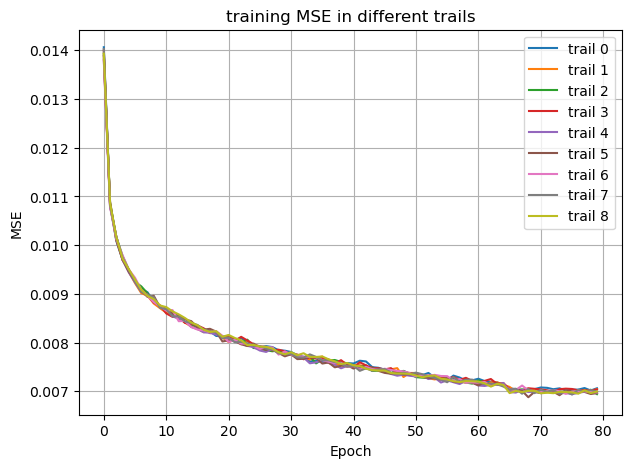

In [77]:
# training 
x = np.array(train_trails)
plott(A, "training")

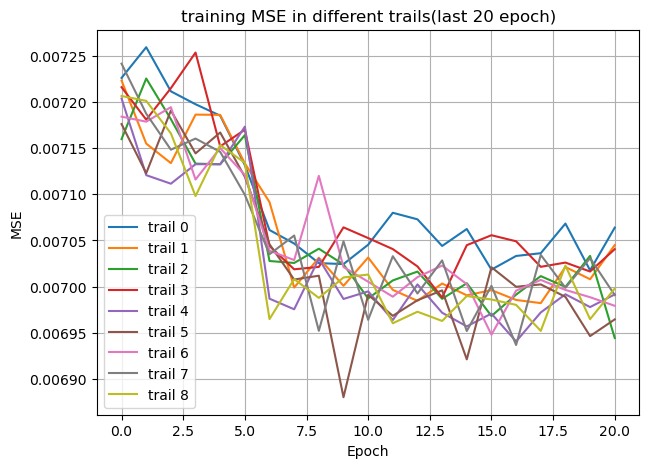

In [78]:
# training 
x = np.array(train_trails)
plott_20(x, "training")

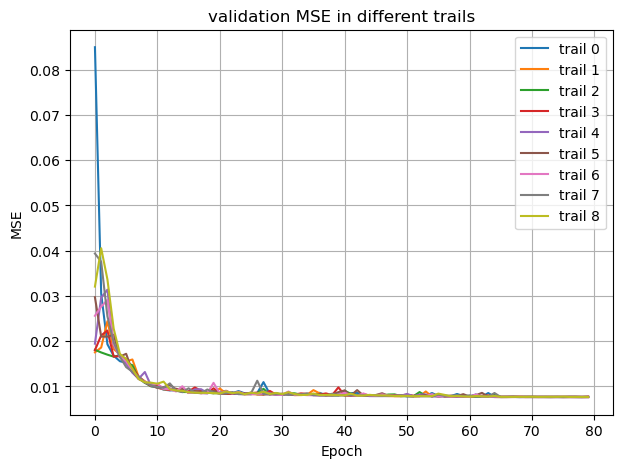

In [79]:
# validation
x = np.array(validate_trails)
plott(x, "validation")

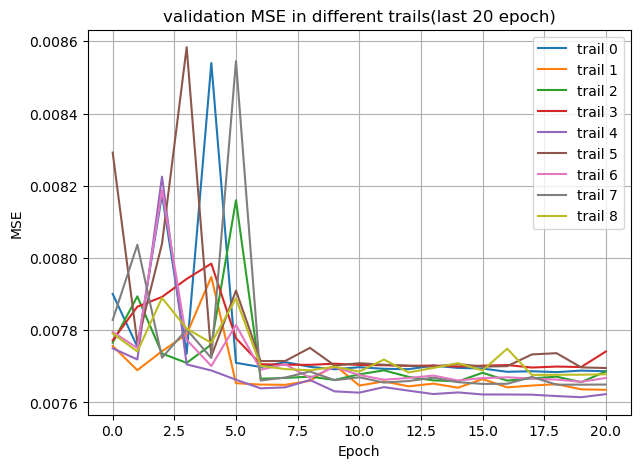

In [80]:
# validation
x = np.array(validate_trails)
plott_20(x, "validation")

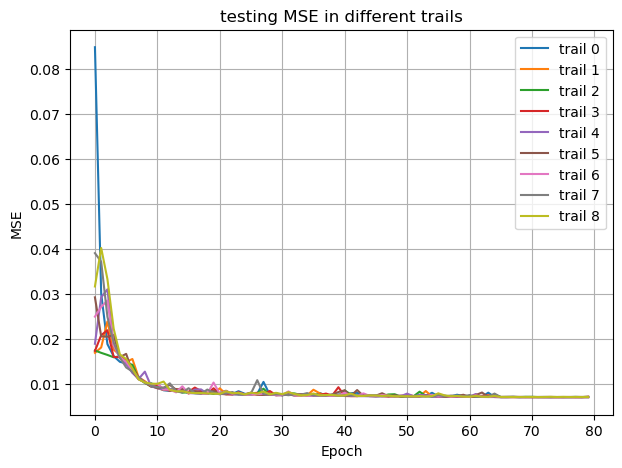

In [81]:
# testing 
x = np.array(test_trails)
plott(x, "testing")

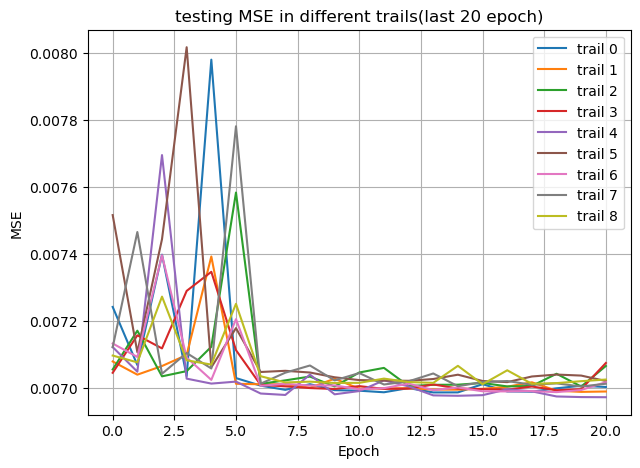

In [82]:
# testng
x =  np.array(test_trails)
plott_20(x, "testing")

## plot the best velidation MSE and testing MSE

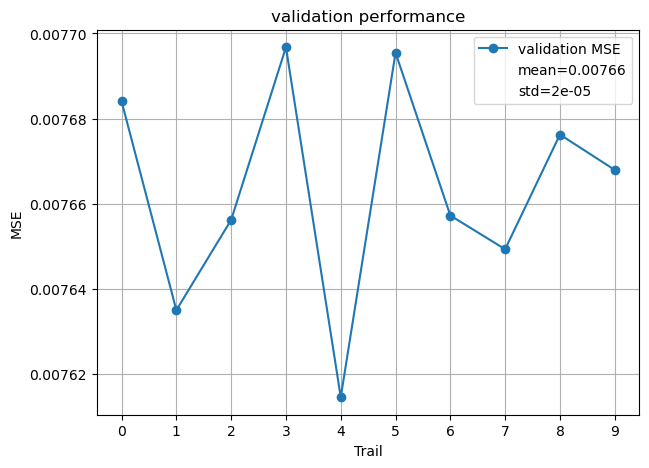

validation mean= 0.0076632786090985285
validation std= 2.4974574428368494e-05


In [83]:
x = vali
plt.figure(figsize=(7,5))
plt.title('validation performance')
plt.plot(x, label='validation MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("validation mean=",np.mean(x))
print("validation std=",np.std(x))

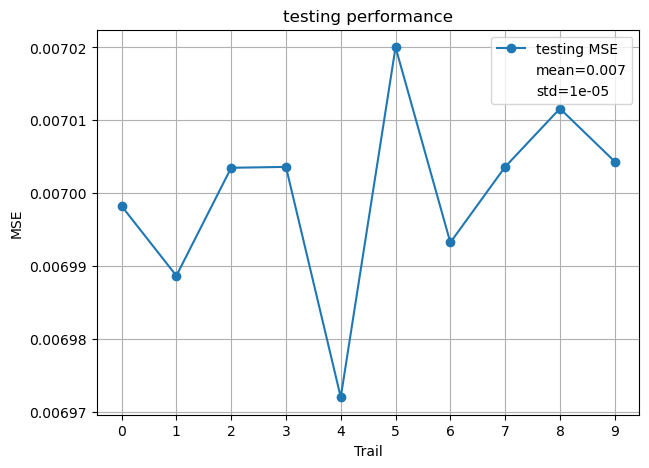

testing mean= 0.006999872116347616
testing std= 1.2470745415284193e-05


In [85]:
x = testing
plt.figure(figsize=(7,5))
plt.title('testing performance')
plt.plot(x, label='testing MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("testing mean=",np.mean(x))
print("testing std=",np.std(x))

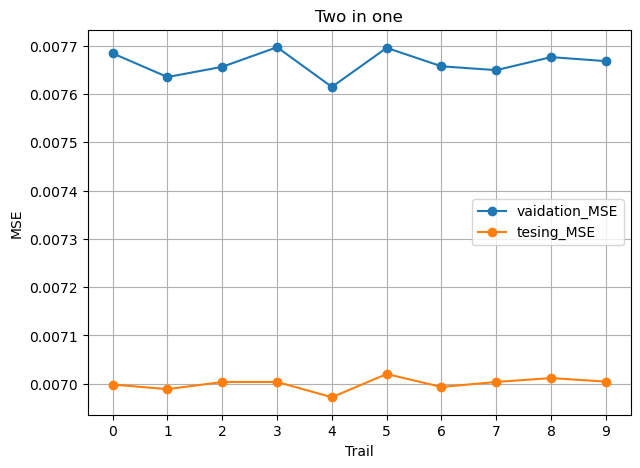

In [86]:
x1 = vali
x2 = testing
plt.figure(figsize=(7,5))
plt.title('Two in one')
plt.plot(x1, label='vaidation_MSE',marker='o')
plt.plot(x2, label='tesing_MSE',marker='o')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()

## Save CSV

In [89]:
x1 = np.array(vali).reshape(1, -1)
x2 = np.array(testing).reshape(1, -1)
two = np.vstack((x1,x2))
df = pd.DataFrame(two).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\spectrogram_s2.csv")

In [90]:
# save data 
x1 = np.array(train_trails).reshape(1, -1)
x2 = np.array(validate_trails).reshape(1, -1)
x3 = np.array(test_trails).reshape(1, -1)
three = np.vstack((x1,x2, x3))
df = pd.DataFrame(three).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\spectrogram_whole_s2.csv")